# [시작 단계] 코드 수정해서 실행해보기

In [2]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH = "/Users/leodi/git/link_dl"
    #str(Path(__file__).resolve().parent.parent.parent))  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores()
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3529),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3529),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms


if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(
        mode="online",
        config=config
    )

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()


/Users/leodi/git/link_dl
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 16

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


# [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 std 값 찾기

In [4]:
data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3)
print(imgs.shape)
# >>> torch.Size([1, 28, 28, 55000])

print(imgs.view(1, -1).mean(dim=-1))
# >>> tensor([0.2860])

print(imgs.view(1, -1).std(dim=-1))
# >>> tensor([0.3529])

torch.Size([1, 28, 28, 55000])
tensor([0.2860])
tensor([0.3529])


### 문제 1번 설명
학습 데이터셋 전체를 하나의 텐서로 결합하여 픽셀 값의 분포를 분석했습니다. 데이터는 28x28 크기의 흑백 이미지 55,000장으로 구성되어 있으며 이를 바탕으로 전체 픽셀의 평균과 표준편차를 계산했습니다.

# [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [10]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from datetime import datetime
import os
import wandb
from pathlib import Path

# !pip install torchinfo

BASE_PATH = "/Users/leodi/git/link_dl"
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = str(Path.cwd())
    #os.path.dirname(os.path.abspath(__file__)))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from datetime import datetime
import torch
from torch import nn

import os
import torch

def get_num_cpu_cores():
    return os.cpu_count()

class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Will be explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      # input_train.shape: torch.Size([2048, 3, 32, 32]),  target_train.shape: torch.Size([2048])
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)
      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=-1)

      # >>> predicted_train: tensor([5, 8, 9, 0, 9, 8, 9, 8, ..., 0, 1, 3, 7, 1, 4, 3])
      # >>> target_train:    tensor([5, 8, 9, 2, 9, 8, 7, 8, ..., 4, 1, 9, 6, 1, 4, 3])
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self, scheduler=None):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()
    max_val_accuracy = 0.0
    best_epoch = 0

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if scheduler:
        scheduler.step()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        if validation_accuracy > max_val_accuracy:
            max_val_accuracy = validation_accuracy
            best_epoch = epoch

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"Best V_Acc: {max_val_accuracy:6.4f} at Epoch {best_epoch} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Best Validation accuracy (%)": max_val_accuracy,
          "Best Validation epoch": best_epoch,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2_048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.00001,
    help="Delta value of early stop (float, default: 0.00001)"
  )

  return parser

def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    # print("Num Train Samples: ", len(f_mnist_train))
    # print("Num Validation Samples: ", len(f_mnist_validation))
    # print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    # num_data_loading_workers = get_num_cpu_cores()
    num_data_loading_workers = 0

    # print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3529),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3529),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

def get_resnet_model(num_classes=10, dropout_rate=0.5):
    class ResnetBlock(nn.Module):
        def __init__(self, out_channels, stride=1, downsample=None):
            super(ResnetBlock, self).__init__()
            self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.LazyBatchNorm2d()
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.LazyBatchNorm2d()
            self.downsample = downsample

        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out += identity
            out = self.relu(out)

            return out

    class ResNet(nn.Module):
        def __init__(self, dropout_p=0.0):
            super(ResNet, self).__init__()
            # Fashion MNIST 28x28이기에 맞춰서 3x3 Conv 사용
            self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.LazyBatchNorm2d()
            self.relu = nn.ReLU(inplace=True)

            # ResNet Layers
            self.layer1 = self._make_layer(64, 2, stride=1)
            self.layer2 = self._make_layer(128, 2, stride=2)
            self.layer3 = self._make_layer(256, 2, stride=2)
            self.layer4 = self._make_layer(512, 2, stride=2)

            self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.LazyLinear(num_classes)

            self.dropout = nn.Dropout(p=dropout_p)
            self.fc = nn.LazyLinear(num_classes)

        def _make_layer(self, out_channels, blocks, stride):
            downsample = None

            if stride != 1:
                downsample = nn.Sequential(
                    nn.LazyConv2d(out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.LazyBatchNorm2d()
                )

            layers = []
            layers.append(ResnetBlock(out_channels, stride=stride, downsample=downsample))

            for _ in range(1, blocks):
                layers.append(ResnetBlock(out_channels))
            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avg_pool(x)
            x = torch.flatten(x, 1)

            x = self.dropout(x)
            x = self.fc(x)
            return x

    return ResNet(dropout_p=dropout_rate)

def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 16 x 4 x 4 --> B x 256
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta
  }

  project_name = "cnn_fashion_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="mnist experiment with cnn",
    tags=["cnn", "fashion_mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
  # model = get_cnn_model()
  model = get_resnet_model(num_classes=10, dropout_rate=0.5)
  model.to(device)

  from torchinfo import summary
  summary(model=model, input_size=(1, 1, 28, 28))

  # 기존 SGD에서 Adam으로 변경
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-3)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=wandb.config.epochs)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop(scheduler)

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=["--wandb", "-b", "64", "-r", "1e-3", "-v", "10"])
  main(args)

Namespace(wandb=True, batch_size=64, epochs=10000, learning_rate=0.001, validation_intervals=10, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 10000, 'batch_size': 64, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
[Epoch   1] T_loss: 0.45173, T_accuracy: 83.9618 | V_loss: 0.35312, V_accuracy: 87.2800 | Best V_Acc: 87.2800 at Epoch 1 | Early stopping is stated! | T_time: 00:00:31, T_speed: 0.032
[Epoch  10] T_loss: 0.19558, T_accuracy: 93.1891 | V_loss: 0.26745, V_accuracy: 90.1200 | Best V_Acc: 90.1200 at Epoch 10 | V_loss decreased (0.35312 --> 0.26745). Saving model... | T_time: 00:04:58, T_speed: 0.034
[Epoch  20] T_loss: 0.15520, T_accuracy: 94.6182 | V_loss: 0.20319, V_accuracy: 93.2400 | Best V_Acc: 93.2400 at Epoch 20 | V_loss decreased (0.26745 --> 0.20319). Saving model... | T_time: 00:09:56, T_speed: 0.034
[Epoch  30] T_loss: 0.13630, T_accuracy: 95.3200 | V_loss: 0.21341, V_ac

KeyboardInterrupt: 

### [문제 2] 설명
초기에는 기본적인 CNN 구조와 SGD 옵티마이저를 사용하여 학습을 시도했으나 목표하는 고성능을 달성하기에는 한계가 있었습니다. 이를 극복하고 Validation Accuracy를 최대한 끌어올리기 위해 다음과 같이 모델 구조와 하이퍼파라미터를 수정했습니다.
최종적으로 배치 사이즈는 64, 학습률은 1e-3, 옵티마이저는 SGD에서 Adam으로 변경했고 Resnet 모델을 이용하도록 변경했습니다.
최종적으로 94%는 못넘겼지만, 93.24라는 가장 높은 Validation 값을 기록했습니다.


# [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

======== Test & Visualization ========
Num Test Samples:  10000
>> Initializing Lazy Modules...
>> Loading Weights from: C:\Users\leodi\git\link_dl\_04_your_code\checkpoints\cnn_fashion_mnist_checkpoint_latest.pt

>> Final Test Accuracy: 92.62%
**************************************************

>> [문제 4] Visualizing 10 Samples...
>> [Review] Image 1: True(T-shirt/top) vs Pred(Pullover)


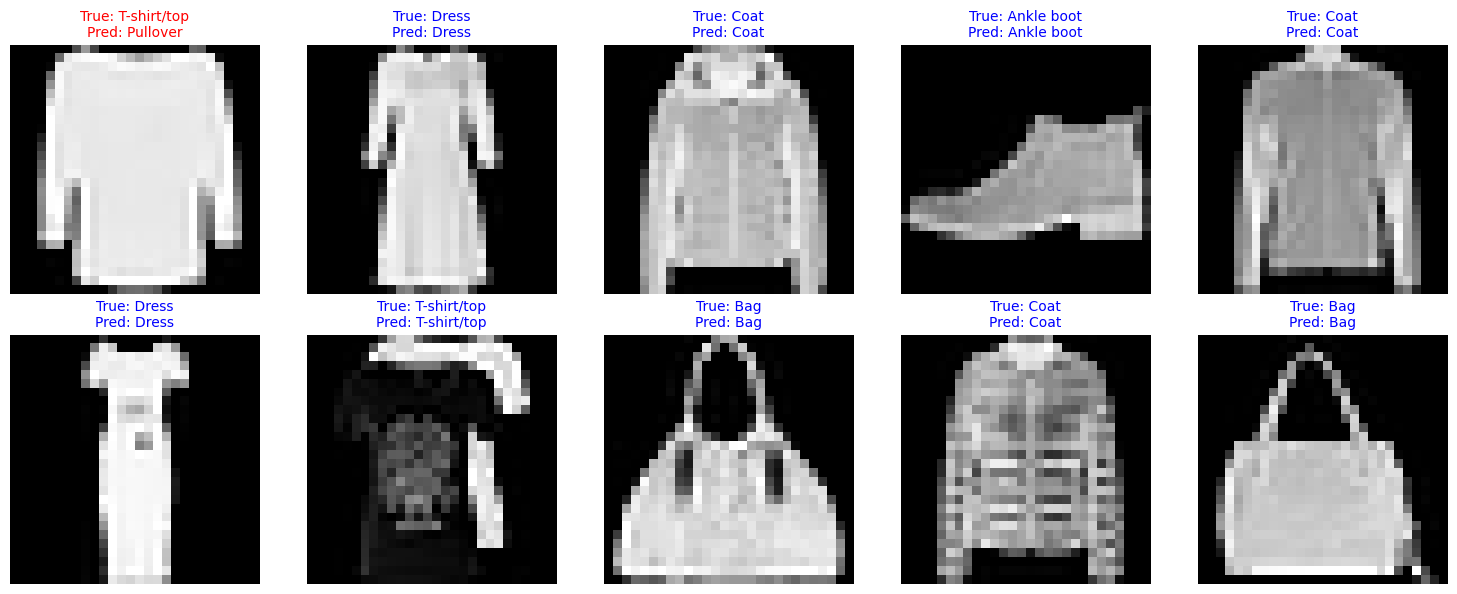

In [18]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys

BASE_PATH = "/Users/leodi/git/link_dl"
if BASE_PATH not in sys.path:
    sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.2860, std=0.3529),
    ])

    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=test_transform)

    print("Num Test Samples: ", len(f_mnist_test))

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=1000, shuffle=False)

    return None, test_data_loader, None

def get_resnet_model(num_classes=10, dropout_rate=0.5):
    class ResnetBlock(nn.Module):
        def __init__(self, out_channels, stride=1, downsample=None):
            super(ResnetBlock, self).__init__()
            self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.LazyBatchNorm2d()
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.LazyBatchNorm2d()
            self.downsample = downsample

        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out += identity
            out = self.relu(out)

            return out

    class ResNet(nn.Module):
        def __init__(self, dropout_p=0.0):
            super(ResNet, self).__init__()
            # Fashion MNIST 28x28이기에 맞춰서 3x3 Conv 사용
            self.conv1 = nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.LazyBatchNorm2d()
            self.relu = nn.ReLU(inplace=True)

            # ResNet Layers
            self.layer1 = self._make_layer(64, 2, stride=1)
            self.layer2 = self._make_layer(128, 2, stride=2)
            self.layer3 = self._make_layer(256, 2, stride=2)
            self.layer4 = self._make_layer(512, 2, stride=2)

            self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.LazyLinear(num_classes)

            self.dropout = nn.Dropout(p=dropout_p)
            self.fc = nn.LazyLinear(num_classes)

        def _make_layer(self, out_channels, blocks, stride):
            downsample = None

            if stride != 1:
                downsample = nn.Sequential(
                    nn.LazyConv2d(out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.LazyBatchNorm2d()
                )

            layers = []
            layers.append(ResnetBlock(out_channels, stride=stride, downsample=downsample))

            for _ in range(1, blocks):
                layers.append(ResnetBlock(out_channels))
            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avg_pool(x)
            x = torch.flatten(x, 1)

            x = self.dropout(x)
            x = self.fc(x)
            return x

    return ResNet(dropout_p=dropout_rate)

def find_best_checkpoint(checkpoint_dir):
    if not os.path.exists(checkpoint_dir): return None
    files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
    if not files: return None
    files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    return os.path.join(checkpoint_dir, files[0])

def main():
    print("======== Test & Visualization ========")
    _, test_loader, _ = get_fashion_mnist_test_data()

    model = get_resnet_model(num_classes=10, dropout_rate=0.5)
    model.to(device)

    print(">> Initializing Lazy Modules...")
    model(torch.randn(1, 1, 28, 28).to(device))

    checkpoint_path = find_best_checkpoint(CHECKPOINT_FILE_PATH)
    if checkpoint_path:
        print(f">> Loading Weights from: {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path))
    else:
        print("[Error] Checkpoint file not found")
        return

    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    _ = model(dummy_input)

    model.eval()
    all_imgs, all_lbls, all_preds = [], [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            total += lbls.size(0)
            correct += (preds == lbls).sum().item()

            all_imgs.append(imgs.cpu())
            all_lbls.append(lbls.cpu())
            all_preds.append(preds.cpu())

    acc = 100 * correct / total
    print(f"\n>> Final Test Accuracy: {acc:.2f}%")

    print(f"*" * 50)

    print("\n>> [문제 4] Visualizing 10 Samples...")
    all_imgs = torch.cat(all_imgs)
    all_lbls = torch.cat(all_lbls)
    all_preds = torch.cat(all_preds)

    incorrect_indices = (all_preds != all_lbls).nonzero(as_tuple=True)[0]
    selected_indices = []

    if len(incorrect_indices) > 0:
        idx = incorrect_indices[torch.randint(len(incorrect_indices), (1,)).item()]
        selected_indices.append(idx.item())

    perm = torch.randperm(len(all_imgs))
    for i in perm:
        if len(selected_indices) == 10: break
        if i.item() not in selected_indices:
            selected_indices.append(i.item())

    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(selected_indices):
        # 이미지 역정규화
        img = all_imgs[idx].squeeze().numpy() * 0.3529 + 0.2860
        img = np.clip(img, 0, 1)

        lbl, pred = all_lbls[idx].item(), all_preds[idx].item()

        axes[i].imshow(img, cmap='gray')
        color = 'blue' if lbl == pred else 'red'
        axes[i].set_title(f"True: {classes[lbl]}\nPred: {classes[pred]}", color=color, fontsize=10)
        axes[i].axis('off')

        if lbl != pred:
             print(f">> [Review] Image {i+1}: True({classes[lbl]}) vs Pred({classes[pred]})")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

### [문제 3] 결과 설명
먼저 학습 과정에서 검증 정확도가 가장 높았던 최적의 모델 파일을 로드하여 학습에 사용하지 않은 테스트 데이터 1만 장에 대해 성능 평가를 수행했습니다.

ResNet 기반 모델 구조를 적용하여 학습한 결과 최종 테스트 정확도는 92.62%를 기록했습니다. 비록 목표 점수인 93%에는 아주 조금 미치지 못했지만, 10가지 패션 아이템 대부분을 알맞게 분류하고 있음을 확인했습니다.

# [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

테스트 데이터 중 무작위로 10개의 샘플을 추출하여 실제 정답과 모델의 예측값을 비교했습니다. 대부분의 이미지를 정확하게 맞추었으나 일부 샘플에서 예측과 정답이 다른 경우가 있었습니다.

특히 T-shirt/top을 Pullover로 잘못 예측하는 문제가 발생했습니다. 제 생각에는 두 가지 모두 상의에 해당하며, Fashion MNIST 이미지 특성상 해상도가 낮아 소매의 길이나 옷감의 두께 같은 특징이 뚜렷하게 구분되지 않기 때문이라고 생각합니다. 모델이 전체적인 실루엣만 보고 판단하다 보니 이 두 가지를 혼동하는 경우가 생기는 것 같습니다.

# [숙제 후기]

이번 과제는 수업 시간에 이론으로만 접했던 CNN과 ResNet 같은 최신 아키텍처를 직접 구현하고 패션 MNIST 데이터셋에 적용해보며 딥러닝 모델의 성능을 극대화해보는 과정이었습니다. 단순히 모델을 돌리는 것을 넘어 목표 정확도인 94퍼센트를 달성하기 위해 다양한 기법을 시도하며 많은 시행착오를 겪었습니다.

가장 기억에 남는 부분은 2번 문제입니다. 2번 문제를 풀면서 목표로 퍼센트를 넘기기 위해서 배치 사이즈나 학습률 등 여러가지 요소를 변경하거나 model을 변경해보는 과정이 시간도 오래 걸렸고 테스트도 매번 해보면서 비교를 해봐야 했기에 힘들었어서 가장 기억에 남는 것 같습니다.

마지막으로, 예측과 정답이 다른 경우를 보고서 생각해보는 과정을 통해 어떻게 해야지 이렇게 유사한 경우에도 구별을 할 수 있을지 더 고민하게 되었습니다.